# Attention Visualization in Transformer Models

## Objective
This notebook demonstrates how to visualize and interpret attention mechanisms in transformer models. We'll:

1. Load a pre-trained model (DistilBERT)
2. Extract attention weights for sample text
3. Create various visualizations of attention patterns
4. Analyze what the model is focusing on

## Key Concepts
- **Attention Mechanism**: How models decide which parts of the input to focus on
- **Multi-Head Attention**: Multiple attention patterns learned in parallel
- **Attention Heads**: Individual attention mechanisms that may capture different linguistic patterns
- **Attention Maps**: Visualizations showing which tokens attend to which other tokens

In [1]:
# Install required packages
!pip install transformers torch matplotlib seaborn bertviz ipywidgets
!pip install datasets  # For additional text examples
!pip install "ipykernel<7" -U
!python -m ipykernel install --user




[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Installed kernelspec python3 in /Users/udaykanwar/Library/Jupyter/kernels/python3


In [1]:
# Import required libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel, AutoConfig
from bertviz import head_view, model_view
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.9.0
GPU available: False


## 1. Model Setup

We'll use **DistilBERT**, a smaller and faster version of BERT that retains most of its performance while being more efficient for our visualization purposes.

### Why DistilBERT?
- **Lightweight**: 6 layers vs BERT's 12 layers
- **Fast inference**: Good for interactive exploration
- **Clear attention patterns**: Well-documented attention behaviors
- **Good for visualization**: Manageable number of attention heads (12 heads per layer)

In [2]:
# Load DistilBERT model and tokenizer
import os
os.environ["TRANSFORMERS_VERBOSITY"] = "error"
model_name = "distilbert-base-uncased"

print("Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name, output_attentions=True)
model = AutoModel.from_pretrained(model_name, config=config)

# Set model to evaluation mode
model.eval()

print(f"Model loaded: {model_name}")
print(f"Number of layers: {config.n_layers}")
print(f"Number of attention heads per layer: {config.n_heads}")
print(f"Hidden size: {config.dim}")
print(f"Vocabulary size: {config.vocab_size}")

Loading model and tokenizer...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Model loaded: distilbert-base-uncased
Number of layers: 6
Number of attention heads per layer: 12
Hidden size: 768
Vocabulary size: 30522


## 2. Text Processing and Attention Extraction

Let's define some sample texts to analyze and create functions to extract attention weights.

In [3]:
def extract_attention(text, model, tokenizer):
    """
    Extract attention weights for a given text.
    
    Args:
        text (str): Input text to analyze
        model: Pre-trained transformer model
        tokenizer: Corresponding tokenizer
    
    Returns:
        tuple: (tokens, attention_weights, input_ids)
    """
    # Tokenize the input
    inputs = tokenizer(text, return_tensors="pt", add_special_tokens=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    
    # Get model outputs with attention
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract attention weights
    # Shape: (num_layers, batch_size, num_heads, seq_len, seq_len)
    attention_weights = outputs.attentions
    
    return tokens, attention_weights, inputs["input_ids"]

# Test the function with sample text
sample_text = "The cat sat on the mat."
tokens, attention_weights, input_ids = extract_attention(sample_text, model, tokenizer)

print(f"Sample text: '{sample_text}'")
print(f"Tokens: {tokens}")
print(f"Number of layers: {len(attention_weights)}")
print(f"Attention shape per layer: {attention_weights[0].shape}")
print(f"(batch_size, num_heads, seq_len, seq_len)")

Sample text: 'The cat sat on the mat.'
Tokens: ['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', '.', '[SEP]']
Number of layers: 6
Attention shape per layer: torch.Size([1, 12, 9, 9])
(batch_size, num_heads, seq_len, seq_len)


### Understanding Output:
- 1 = batch size (we gave one sentence)

- 12 = number of attention heads

- 9 = number of tokens in your sentence (including special tokens)

#### Layers = Levels of Understanding (Depth of the Model)
When text enters the model, it goes through multiple layers, each refining its understanding of meaning:

- Each layer takes the output of the previous layer,

- Learns slightly higher-level patterns.

Example with DistilBERT:

- It has 6 layers (BERT-base has 12).

- The first layer focuses on word-level patterns (like word order).

- The middle layers start combining words into phrases or syntactic structures.

- The later layers capture context and meaning (like “who did what to whom”).

#### Attention Heads = Different “Views” Within a Layer

Inside each layer, the model doesn’t look at the sentence in just one way.
It uses multiple attention heads — parallel “sub-networks,” each focusing on different relationships between words.

You can imagine:

One head tracks subject–verb relationships.

Another might track pronouns and their referents (“he” → “John”).

Another might track word order or negations.

Each head computes its own attention map — telling the model “which words matter for this specific word.”

In [5]:
def plot_attention_head(attention_weights, tokens, layer_idx, head_idx, figsize=(10, 8)):
    """
    Plot attention weights for a specific layer and head.
    
    Args:
        attention_weights: Attention weights from model
        tokens: List of tokens
        layer_idx: Which layer to visualize
        head_idx: Which attention head to visualize
        figsize: Figure size for the plot
    """
    # Extract attention for specific layer and head
    # Shape: (seq_len, seq_len)
    attention = attention_weights[layer_idx][0, head_idx].numpy()
    
    plt.figure(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(
        attention,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap='Blues',
        annot=True,
        fmt='.2f',
        square=True,
        cbar_kws={'label': 'Attention Weight'}
    )
    
    plt.title(f'Attention Head {head_idx}, Layer {layer_idx}')
    plt.xlabel('Keys (attending to)')
    plt.ylabel('Queries (attending from)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_layer_attention_summary(attention_weights, tokens, layer_idx, figsize=(12, 8)):
    """
    Plot average attention across all heads for a specific layer.
    """
    # Average across all heads for this layer
    layer_attention = attention_weights[layer_idx][0].mean(dim=0).numpy()
    
    plt.figure(figsize=figsize)
    
    sns.heatmap(
        layer_attention,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap='Reds',
        annot=True,
        fmt='.2f',
        square=True,
        cbar_kws={'label': 'Average Attention Weight'}
    )
    
    plt.title(f'Layer {layer_idx} - Average Attention Across All Heads')
    plt.xlabel('Keys (attending to)')
    plt.ylabel('Queries (attending from)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 3. Basic Attention Visualization

Let's start with visualizing attention patterns for our sample text: "The cat sat on the mat."

Visualizing different attention heads...


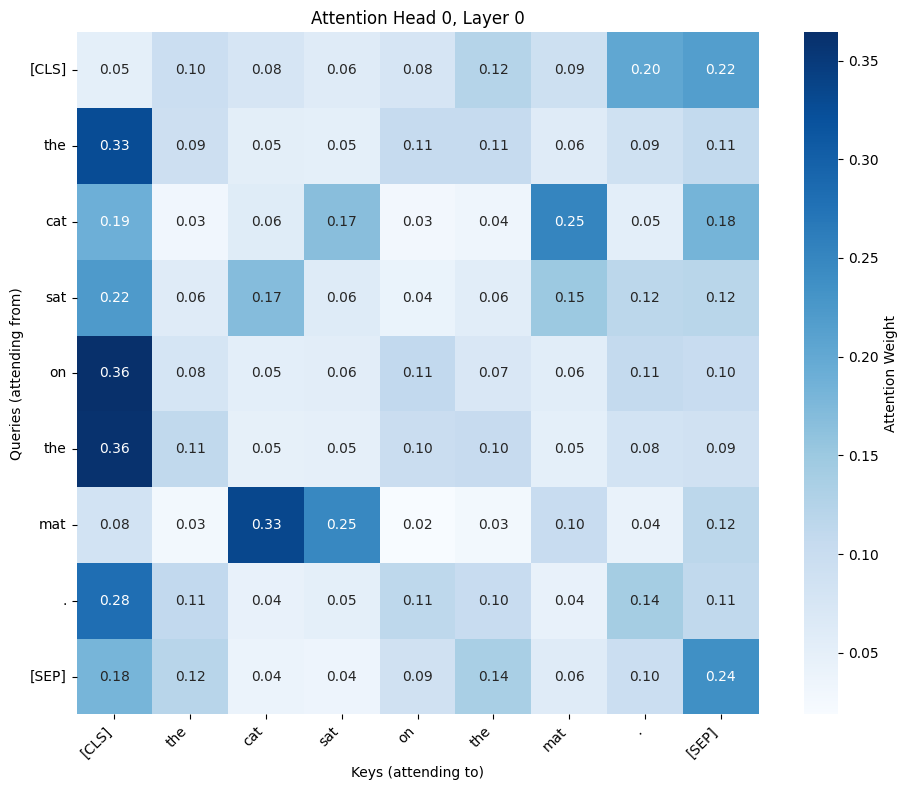

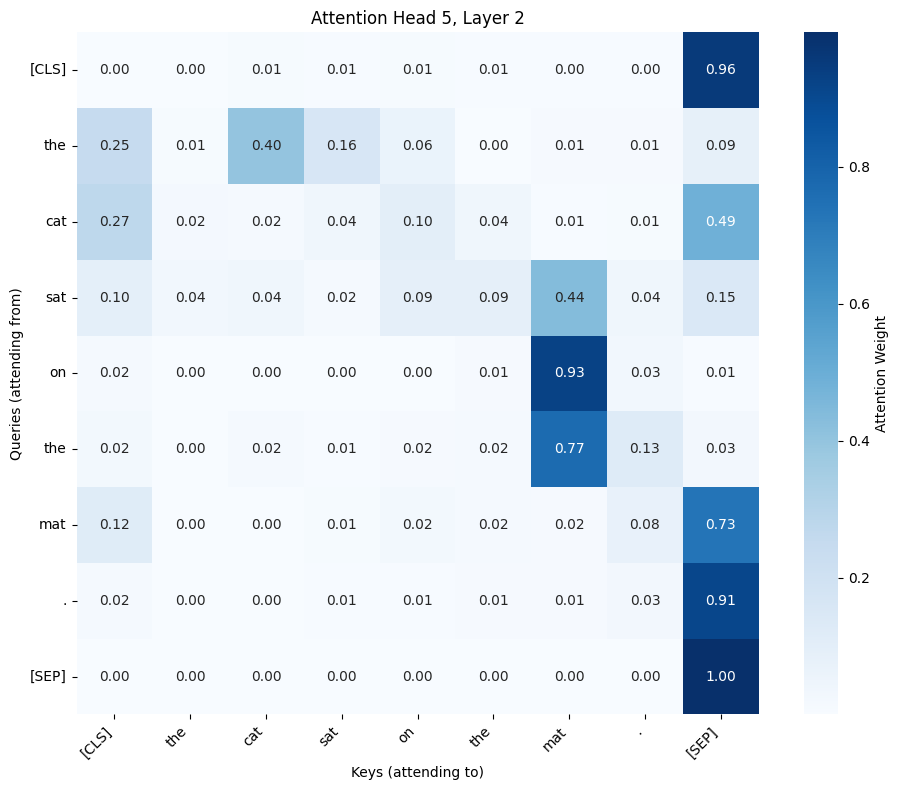

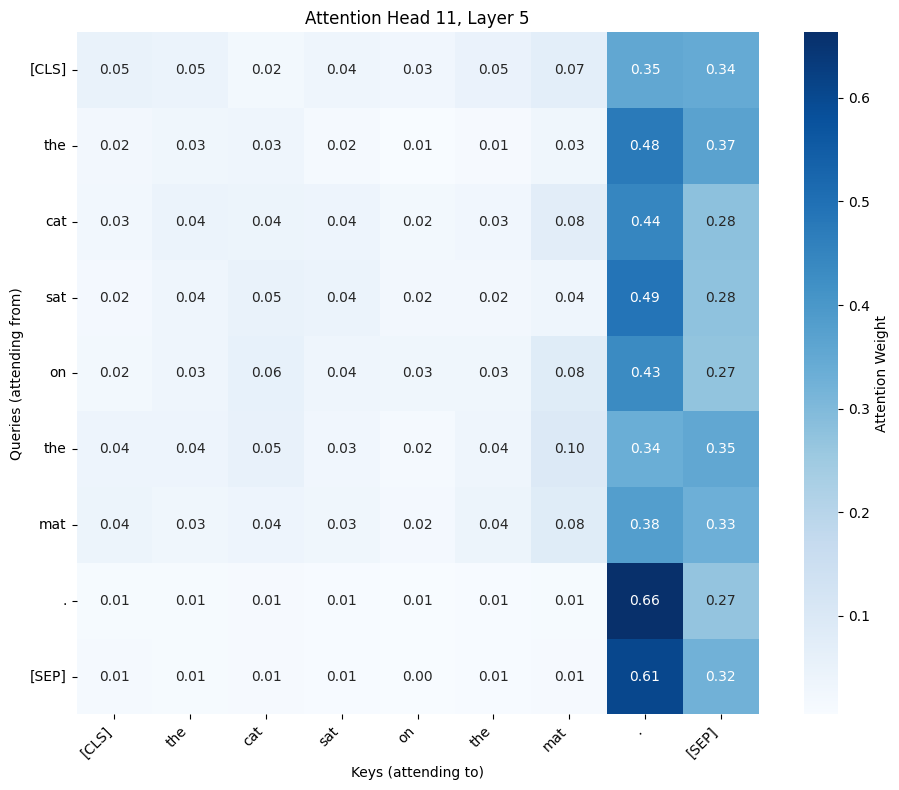

In [6]:
# Visualize attention for specific heads
print("Visualizing different attention heads...")

# Plot attention for the first layer, first head
plot_attention_head(attention_weights, tokens, layer_idx=0, head_idx=0)

# Plot attention for a middle layer, different head
plot_attention_head(attention_weights, tokens, layer_idx=2, head_idx=5)

# Plot attention for the last layer, last head
plot_attention_head(attention_weights, tokens, layer_idx=5, head_idx=11)

## Understading the plots: 
Horizontal axis (x-axis):

- “Keys (attending to)” — the words that are being looked at.

Vertical axis (y-axis):

- “Queries (attending from)” — the words that are doing the looking.

Each cell at row i, column j tells you:

- How much the i-th token focuses on the j-th token when interpreting its meaning.

You can think of this as:

- “For each word, where is the model looking to understand it?”

In the first plot:

- "on" and "the" (the second “the”) have dark cells in the first column ([CLS]), meaning the model links these tokens to the overall sentence representation ([CLS] token).

- "mat" attends to "cat" and "sat" — that’s syntactically sensible (they’re semantically related).

- "." attends to [CLS] and "the" — punctuation often links to the overall structure.

[CLS] (short for classification) is a special token automatically added at the start of every sentence in BERT-like models (including DistilBERT). It serves as a summary representation of the entire sequence — like a “global understanding” of the sentence.
[SEP] stands for “separator.” It’s also a special token used to mark the end of a sentence or to separate two segments of text inside a model.

\nVisualizing average attention across all heads per layer...


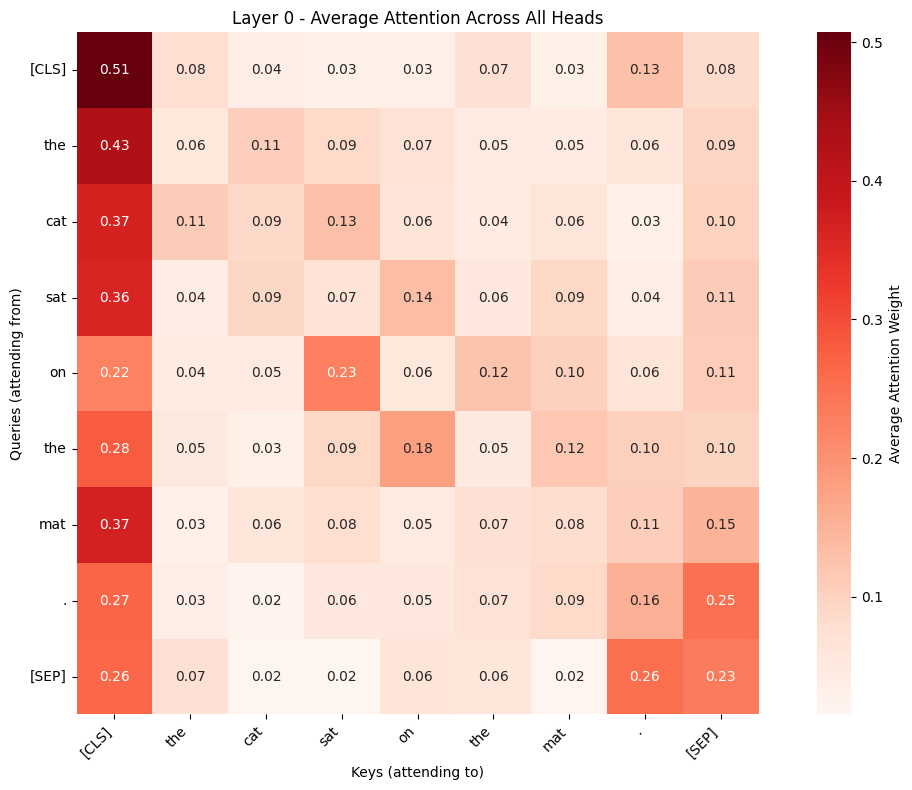

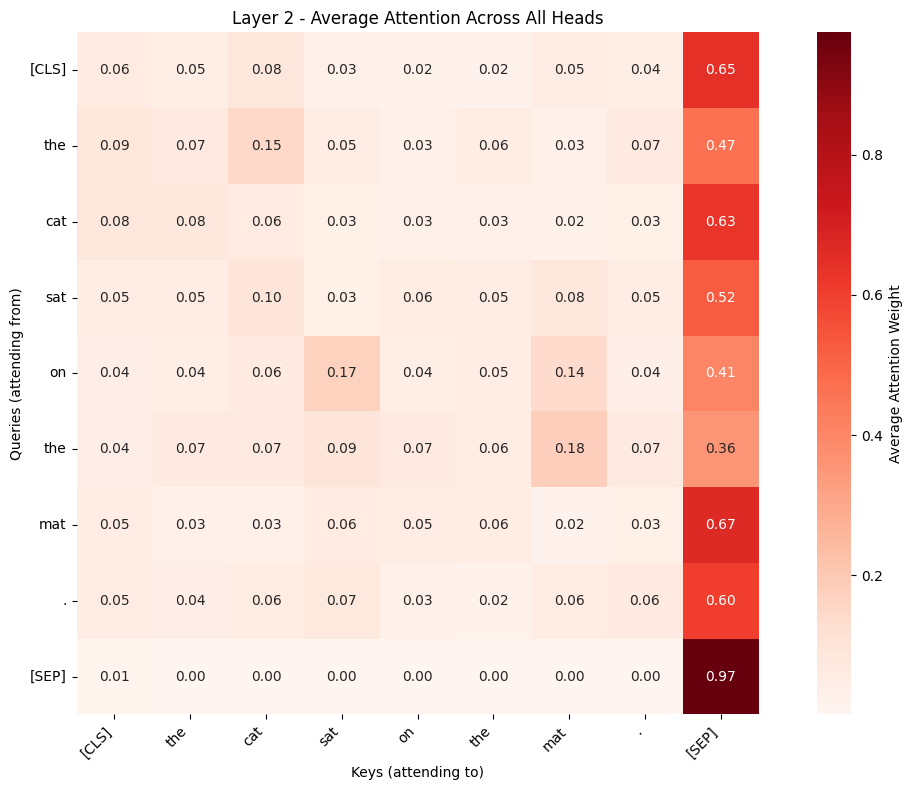

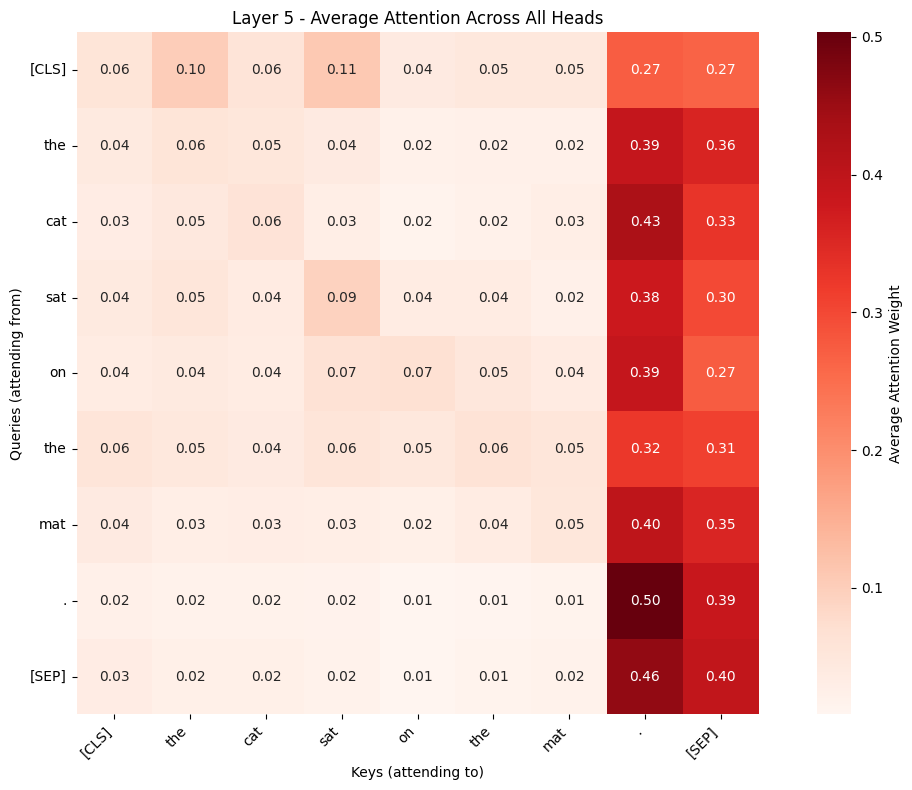

In [7]:
# Visualize average attention per layer
print("\\nVisualizing average attention across all heads per layer...")

# Plot average attention for first, middle, and last layers
for layer_idx in [0, 2, 5]:
    plot_layer_attention_summary(attention_weights, tokens, layer_idx)

The plots above show how much, on average, each token attends to every other token in this layer. Instead of one head, it’s showing the average attention weights across all 12 attention heads.



## 4. Interactive Attention Visualization with BertViz

BertViz provides interactive visualizations that allow you to explore attention patterns more intuitively.

In [8]:
# Interactive visualization with BertViz
from bertviz import head_view, model_view

# Prepare inputs for BertViz
text = "The cat sat on the mat."
inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]  # Get attention weights

# Convert to format expected by BertViz
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

print("Generating interactive attention visualization...")
print("Note: The visualization will appear below. Click on different heads and layers to explore!")

# Head view - shows attention for individual heads
head_view(attention, tokens)

Generating interactive attention visualization...
Note: The visualization will appear below. Click on different heads and layers to explore!


<IPython.core.display.Javascript object>

| Element             | Meaning                                                       |
| ------------------- | ------------------------------------------------------------- |
| Left side           | Query tokens (the “lookers”)                                  |
| Right side          | Key tokens (the “looked-at”)                                  |
| Colored lines       | Attention connections (thicker/darker = stronger)             |
| Color boxes on top  | Different attention heads                                     |
| Layer dropdown      | Which layer of the model you’re visualizing                   |
| `[CLS]` and `[SEP]` | Sentence start and end tokens, often attract strong attention |

#### Early Patterns
- Early layers: short-distance, syntactic focus (“the → cat”).

- Middle layers: phrase-level dependencies (“sat → on”, “on → mat”).

- Final layers: global attention (“[CLS]” connects to all tokens).

This mirrors how humans process language: first grammar, then structure, then meaning.

In [9]:
# Model view - shows attention across all layers and heads
print("\\nModel view - Overview of all layers and heads:")
model_view(attention, tokens)

\nModel view - Overview of all layers and heads:


<IPython.core.display.Javascript object>

## 5. Analyzing Different Text Types

Let's explore how attention patterns change with different types of text and linguistic structures.

\n============================================================
Analyzing: 'The cat sat on the mat.'
Tokens: ['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', '.', '[SEP]']


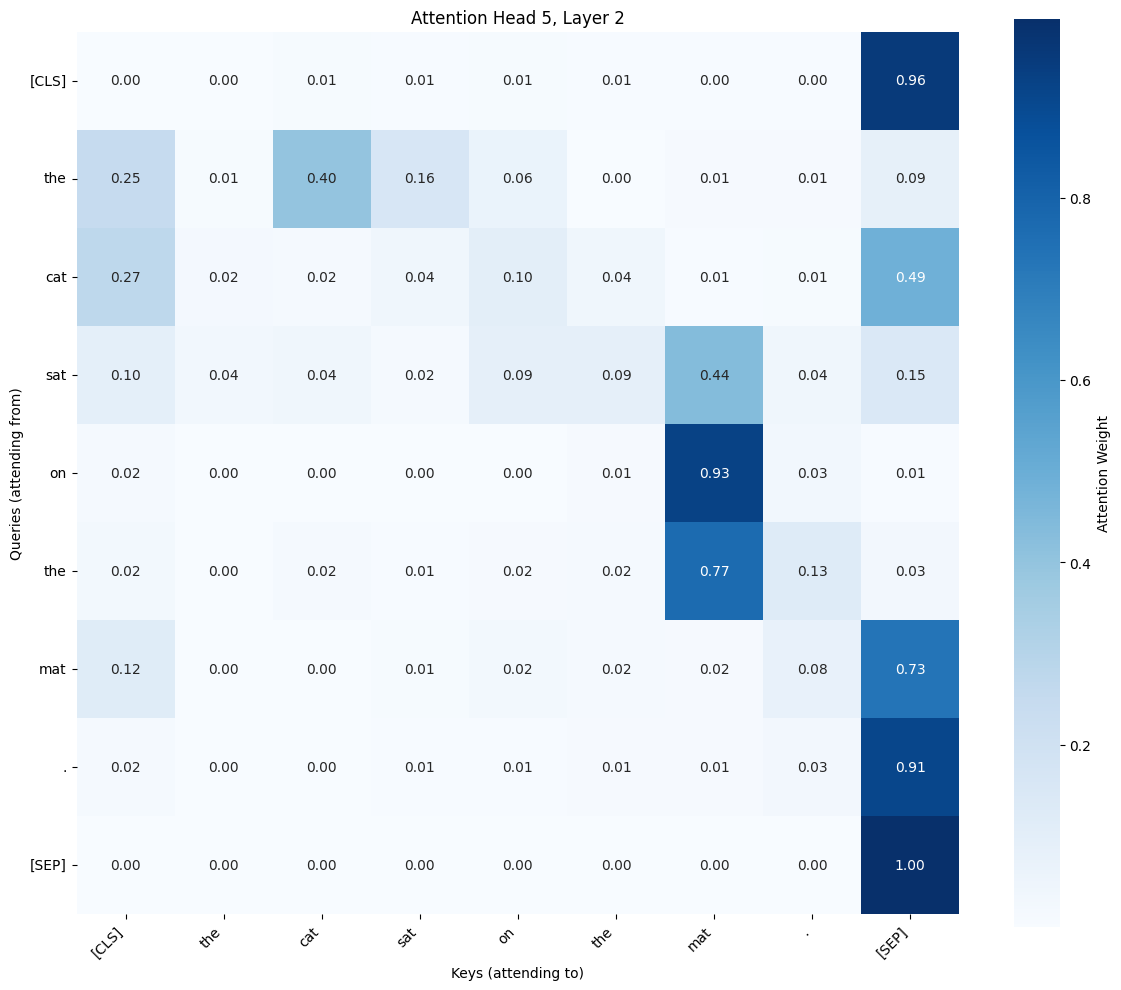

\nTop 5 attention connections:
[CLS] -> the: 0.003
[CLS] -> cat: 0.009
[CLS] -> sat: 0.006
[CLS] -> on: 0.010
[CLS] -> the: 0.007
[CLS] -> mat: 0.005
[CLS] -> .: 0.005
[CLS] -> [SEP]: 0.955
the -> [CLS]: 0.249
the -> cat: 0.398
the -> sat: 0.160
the -> on: 0.064
the -> the: 0.004
the -> mat: 0.013
the -> .: 0.015
the -> [SEP]: 0.088
cat -> [CLS]: 0.274
cat -> the: 0.020
cat -> sat: 0.042
cat -> on: 0.103
cat -> the: 0.039
cat -> mat: 0.007
cat -> .: 0.009
cat -> [SEP]: 0.488
sat -> [CLS]: 0.097
sat -> the: 0.035
sat -> cat: 0.040
sat -> on: 0.091
sat -> the: 0.092
sat -> mat: 0.440
sat -> .: 0.041
sat -> [SEP]: 0.147
on -> [CLS]: 0.016
on -> the: 0.000
on -> cat: 0.002
on -> sat: 0.000
on -> the: 0.012
on -> mat: 0.927
on -> .: 0.033
on -> [SEP]: 0.005
the -> [CLS]: 0.024
the -> the: 0.000
the -> cat: 0.016
the -> sat: 0.007
the -> on: 0.015
the -> mat: 0.768
the -> .: 0.125
the -> [SEP]: 0.028
mat -> [CLS]: 0.120
mat -> the: 0.000
mat -> cat: 0.002
mat -> sat: 0.009
mat -> on: 0.024
m

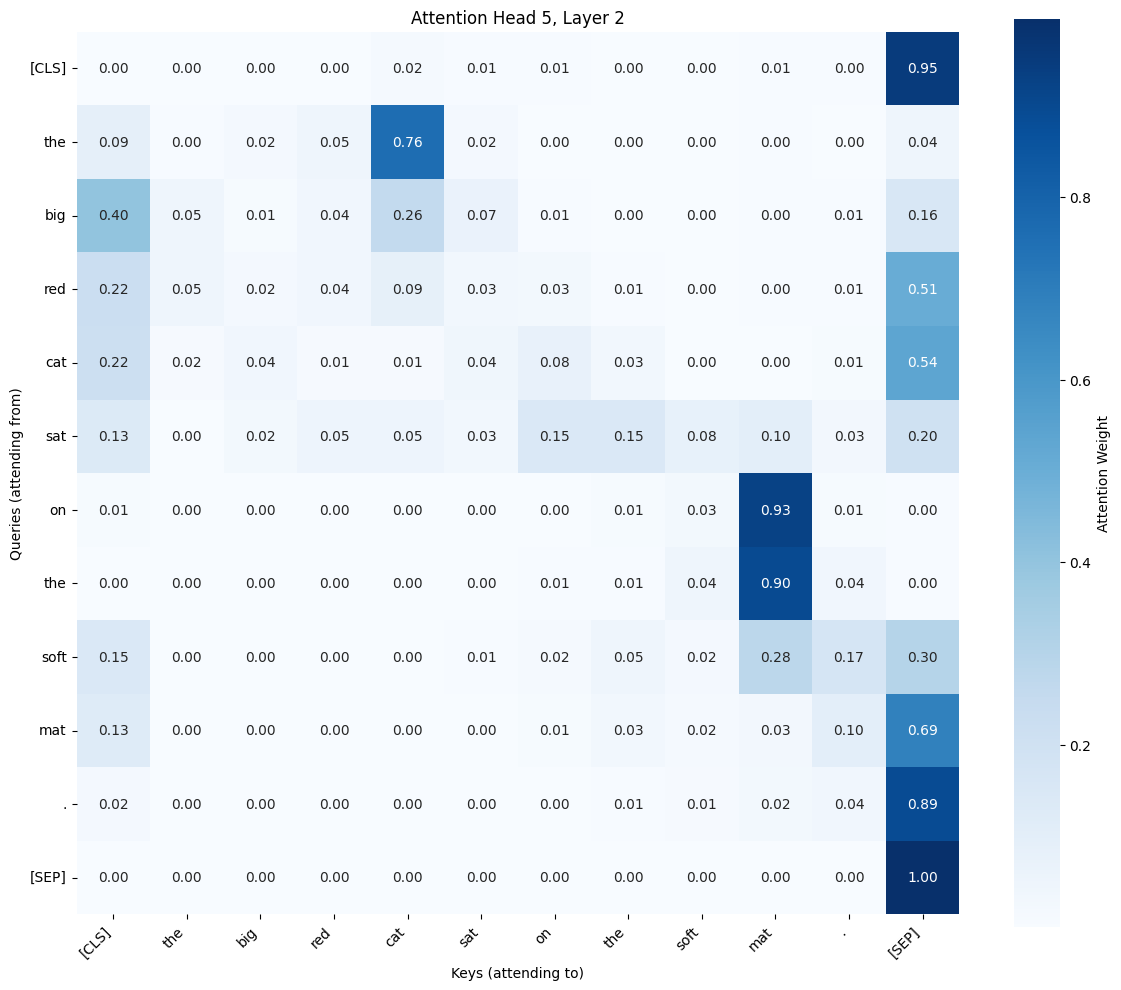

\nTop 5 attention connections:
[CLS] -> the: 0.003
[CLS] -> big: 0.001
[CLS] -> red: 0.002
[CLS] -> cat: 0.016
[CLS] -> sat: 0.006
[CLS] -> on: 0.006
[CLS] -> the: 0.004
[CLS] -> soft: 0.001
[CLS] -> mat: 0.006
[CLS] -> .: 0.004
[CLS] -> [SEP]: 0.950
the -> [CLS]: 0.091
the -> big: 0.020
the -> red: 0.048
the -> cat: 0.759
the -> sat: 0.023
the -> on: 0.004
the -> the: 0.000
the -> soft: 0.001
the -> mat: 0.005
the -> .: 0.003
the -> [SEP]: 0.043
big -> [CLS]: 0.401
big -> the: 0.047
big -> red: 0.036
big -> cat: 0.259
big -> sat: 0.070
big -> on: 0.007
big -> the: 0.001
big -> soft: 0.000
big -> mat: 0.005
big -> .: 0.005
big -> [SEP]: 0.157
red -> [CLS]: 0.223
red -> the: 0.047
red -> big: 0.022
red -> cat: 0.086
red -> sat: 0.034
red -> on: 0.025
red -> the: 0.007
red -> soft: 0.001
red -> mat: 0.004
red -> .: 0.006
red -> [SEP]: 0.509
cat -> [CLS]: 0.218
cat -> the: 0.015
cat -> big: 0.038
cat -> red: 0.013
cat -> sat: 0.042
cat -> on: 0.076
cat -> the: 0.034
cat -> soft: 0.002
cat

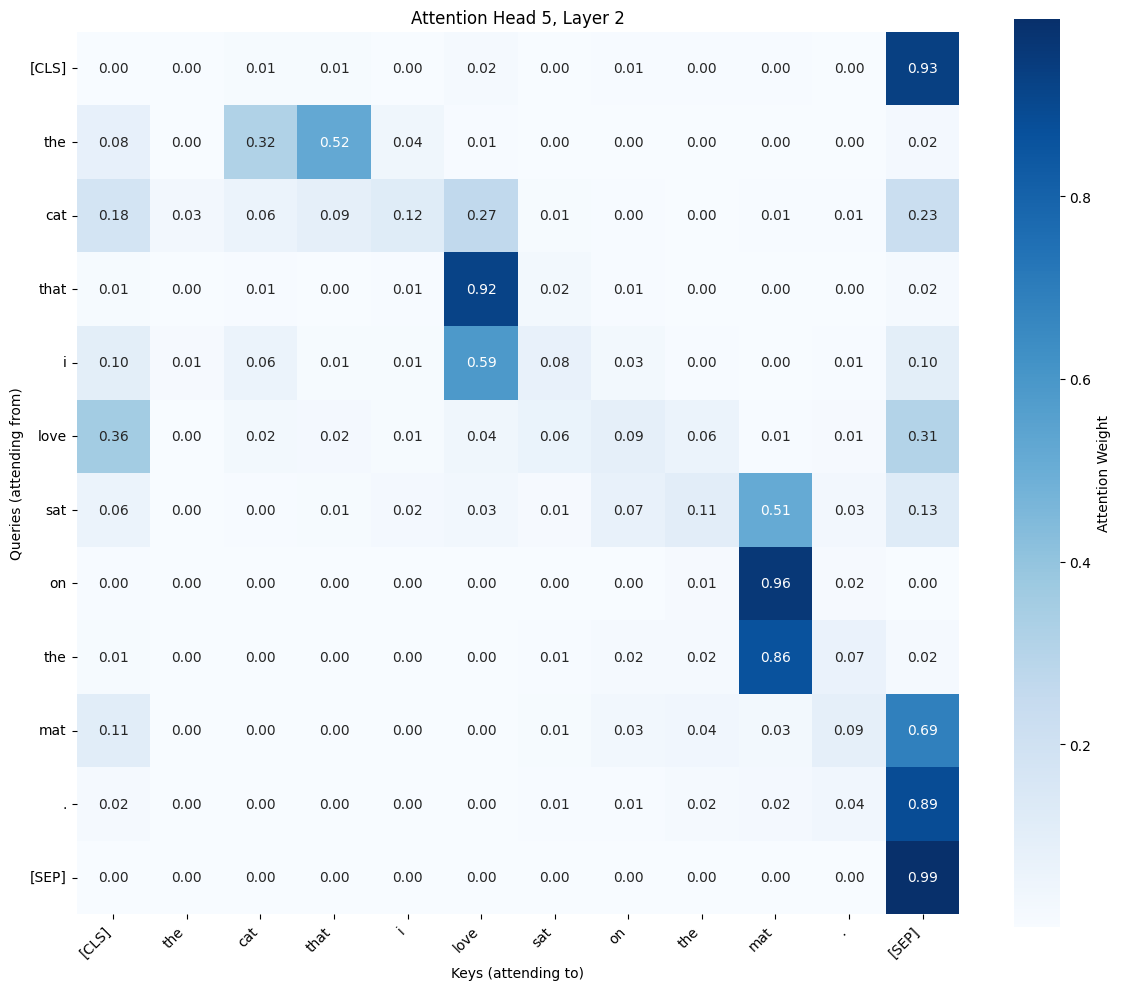

\nTop 5 attention connections:
[CLS] -> the: 0.004
[CLS] -> cat: 0.010
[CLS] -> that: 0.010
[CLS] -> i: 0.004
[CLS] -> love: 0.016
[CLS] -> sat: 0.003
[CLS] -> on: 0.005
[CLS] -> the: 0.004
[CLS] -> mat: 0.005
[CLS] -> .: 0.004
[CLS] -> [SEP]: 0.934
the -> [CLS]: 0.083
the -> cat: 0.316
the -> that: 0.522
the -> i: 0.043
the -> love: 0.006
the -> sat: 0.003
the -> on: 0.001
the -> the: 0.000
the -> mat: 0.002
the -> .: 0.001
the -> [SEP]: 0.019
cat -> [CLS]: 0.181
cat -> the: 0.028
cat -> that: 0.090
cat -> i: 0.119
cat -> love: 0.268
cat -> sat: 0.009
cat -> on: 0.004
cat -> the: 0.001
cat -> mat: 0.007
cat -> .: 0.006
cat -> [SEP]: 0.227
that -> [CLS]: 0.011
that -> the: 0.002
that -> cat: 0.007
that -> i: 0.006
that -> love: 0.922
that -> sat: 0.024
that -> on: 0.005
that -> the: 0.000
that -> mat: 0.001
that -> .: 0.003
that -> [SEP]: 0.018
i -> [CLS]: 0.103
i -> the: 0.013
i -> cat: 0.061
i -> that: 0.010
i -> love: 0.588
i -> sat: 0.077
i -> on: 0.026
i -> the: 0.004
i -> mat: 0.

In [10]:
# Define different types of sentences to analyze
test_sentences = [
    "The cat sat on the mat.",                    # Simple sentence
    "The big red cat sat on the soft mat.",      # Sentence with adjectives
    "The cat that I love sat on the mat.",       # Sentence with relative clause
    "When the cat sat down, the mat moved.",     # Complex sentence with subordinate clause
    "The cat and the dog played together.",      # Sentence with coordination
    "She said that the cat was sleeping."        # Sentence with reported speech
]

def analyze_sentence_attention(sentence, layer_idx=2, head_idx=5):
    """Analyze attention for a sentence and provide insights."""
    tokens, attention_weights, _ = extract_attention(sentence, model, tokenizer)
    
    print(f"\\n{'='*60}")
    print(f"Analyzing: '{sentence}'")
    print(f"Tokens: {tokens}")
    print(f"{'='*60}")
    
    # Plot attention for specified layer and head
    plot_attention_head(attention_weights, tokens, layer_idx, head_idx, figsize=(12, 10))
    
    # Extract attention matrix for analysis
    attention_matrix = attention_weights[layer_idx][0, head_idx].numpy()
    
    # Find highest attention connections
    print("\\nTop 5 attention connections:")
    for i in range(len(tokens)):
        for j in range(len(tokens)):
            if i != j:  # Skip self-attention
                print(f"{tokens[i]} -> {tokens[j]}: {attention_matrix[i,j]:.3f}")
    
    # Sort and show top connections
    connections = []
    for i in range(len(tokens)):
        for j in range(len(tokens)):
            if i != j:
                connections.append((tokens[i], tokens[j], attention_matrix[i,j]))
    
    connections.sort(key=lambda x: x[2], reverse=True)
    print("\\nStrongest attention connections:")
    for src, tgt, weight in connections[:5]:
        print(f"  {src} -> {tgt}: {weight:.3f}")

# Analyze the first few sentences
for sentence in test_sentences[:3]:
    analyze_sentence_attention(sentence)

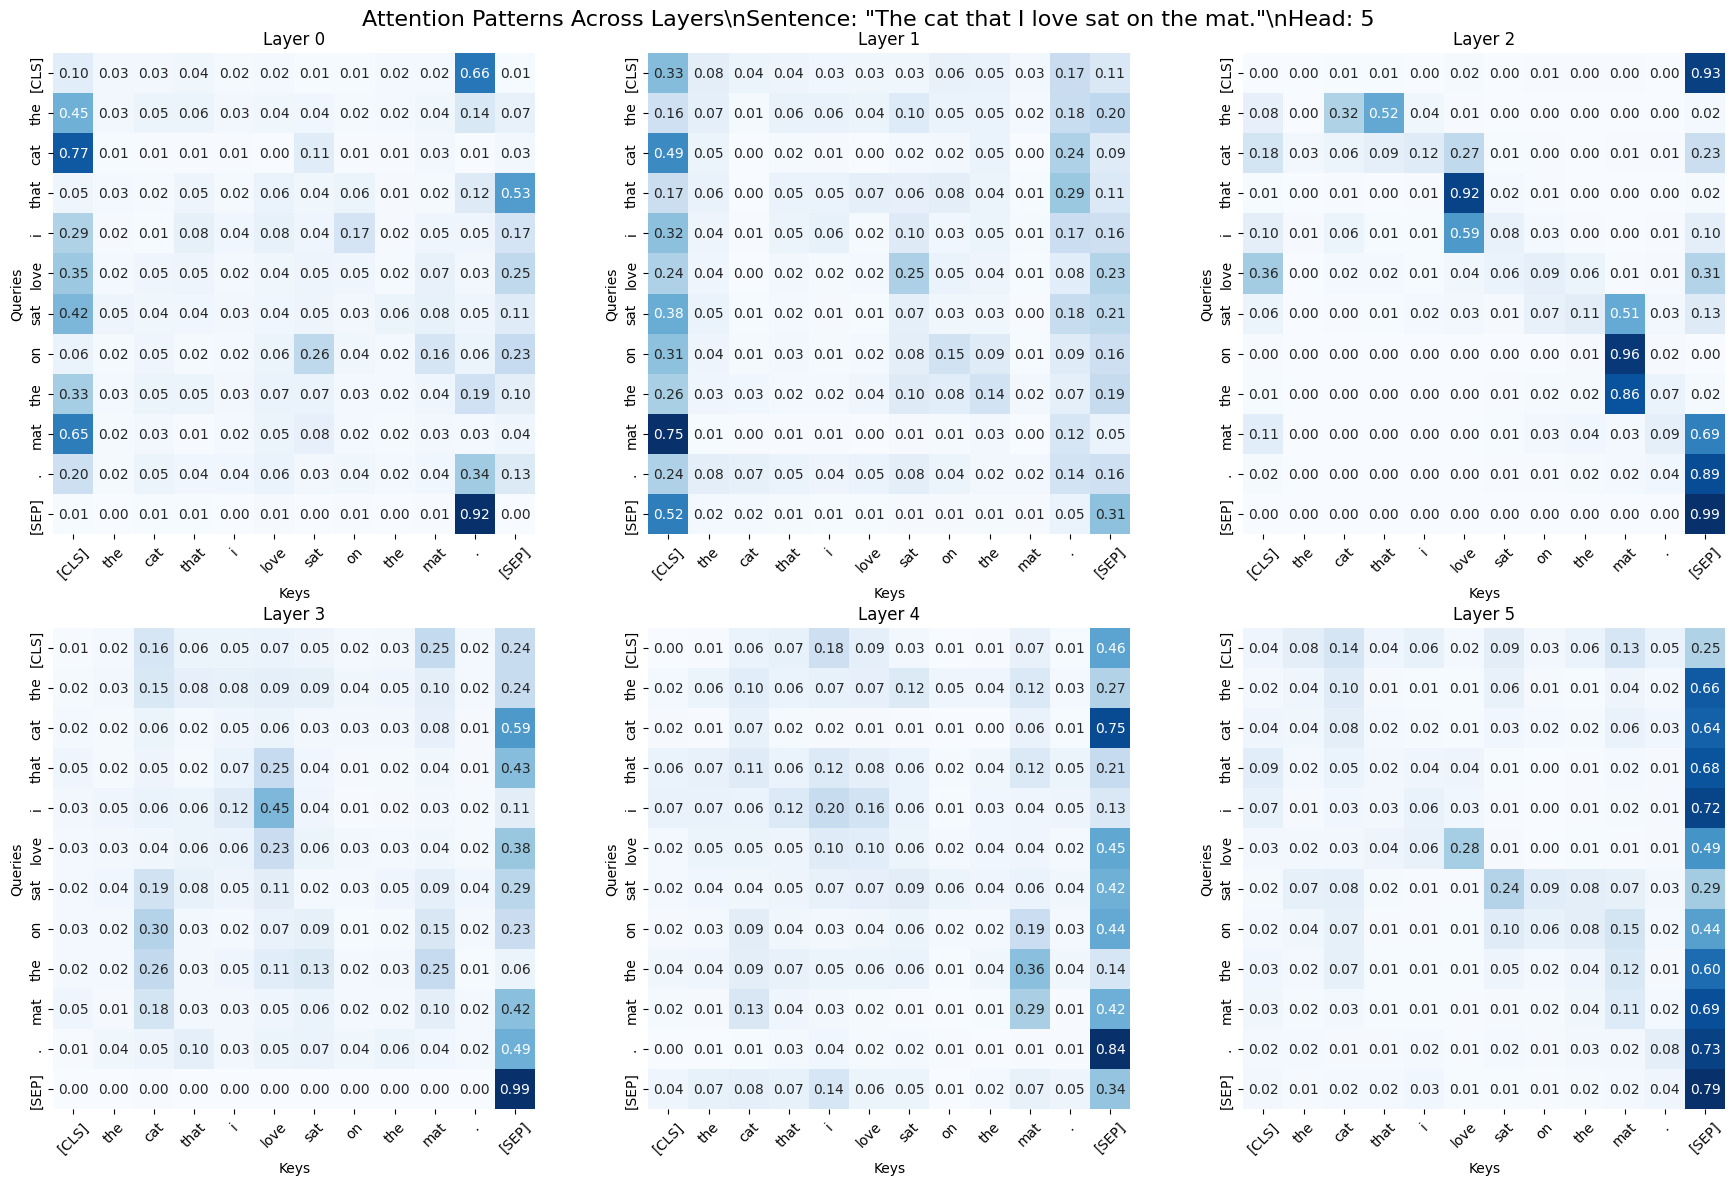

In [11]:
# Function to compare attention patterns across layers
def compare_layers_attention(sentence, head_idx=5):
    """Compare attention patterns across different layers for the same sentence."""
    tokens, attention_weights, _ = extract_attention(sentence, model, tokenizer)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for layer_idx in range(6):  # DistilBERT has 6 layers
        attention = attention_weights[layer_idx][0, head_idx].numpy()
        
        sns.heatmap(
            attention,
            xticklabels=tokens,
            yticklabels=tokens,
            cmap='Blues',
            annot=True,
            fmt='.2f',
            square=True,
            ax=axes[layer_idx],
            cbar=False
        )
        
        axes[layer_idx].set_title(f'Layer {layer_idx}')
        axes[layer_idx].set_xlabel('Keys')
        axes[layer_idx].set_ylabel('Queries')
        axes[layer_idx].tick_params(axis='x', rotation=45)
    
    plt.suptitle(f'Attention Patterns Across Layers\\nSentence: "{sentence}"\\nHead: {head_idx}', 
                 fontsize=16)
    plt.tight_layout()
    plt.show()

# Compare layers for a complex sentence
complex_sentence = "The cat that I love sat on the mat."
compare_layers_attention(complex_sentence)

What you’re looking at above is how one attention head (head 5) evolves across all 6 layers of DistilBERT for the sentence.

## 6. Attention Pattern Analysis & Observations

Based on the visualizations above, let's document key observations about what attention appears to be focusing on.

In [12]:
# Systematic analysis of attention patterns
def analyze_attention_patterns(sentence):
    """
    Systematically analyze and categorize attention patterns in a sentence.
    """
    tokens, attention_weights, _ = extract_attention(sentence, model, tokenizer)
    print(f"\\nAnalyzing patterns in: '{sentence}'")
    print(f"Tokens: {tokens}")
    
    patterns = {
        'positional': [],      # Attention to adjacent positions
        'syntactic': [],       # Attention following syntactic structure
        'semantic': [],        # Attention between semantically related words
        'special_tokens': []   # Attention involving [CLS], [SEP]
    }
    
    # Analyze each layer
    for layer_idx in range(len(attention_weights)):
        layer_attention = attention_weights[layer_idx][0].mean(dim=0).numpy()  # Average across heads
        
        # Find strong attention connections (threshold = 0.1)
        strong_connections = []
        for i in range(len(tokens)):
            for j in range(len(tokens)):
                if layer_attention[i, j] > 0.1 and i != j:
                    strong_connections.append((i, j, tokens[i], tokens[j], layer_attention[i, j]))
        
        print(f"\\nLayer {layer_idx} - Strong connections (>0.1):")
        for i, j, token_i, token_j, weight in strong_connections:
            print(f"  {token_i} -> {token_j}: {weight:.3f}")
            
            # Categorize the connection
            if abs(i - j) == 1:
                patterns['positional'].append((layer_idx, token_i, token_j, weight))
            elif token_i in ['[CLS]', '[SEP]'] or token_j in ['[CLS]', '[SEP]']:
                patterns['special_tokens'].append((layer_idx, token_i, token_j, weight))
            elif token_i in ['the', 'a', 'an'] and token_j not in ['[CLS]', '[SEP]']:
                patterns['syntactic'].append((layer_idx, token_i, token_j, weight))
            else:
                patterns['semantic'].append((layer_idx, token_i, token_j, weight))
    
    return patterns

# Analyze patterns for different sentence types
sentences_to_analyze = [
    "The cat sat on the mat.",
    "The big red cat sat on the soft mat.",
    "The cat that I love sat on the mat."
]

all_patterns = {}
for sentence in sentences_to_analyze:
    all_patterns[sentence] = analyze_attention_patterns(sentence)

\nAnalyzing patterns in: 'The cat sat on the mat.'
Tokens: ['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', '.', '[SEP]']
\nLayer 0 - Strong connections (>0.1):
  [CLS] -> .: 0.129
  the -> [CLS]: 0.430
  the -> cat: 0.106
  cat -> [CLS]: 0.366
  cat -> the: 0.110
  cat -> sat: 0.132
  cat -> [SEP]: 0.100
  sat -> [CLS]: 0.361
  sat -> on: 0.136
  sat -> [SEP]: 0.111
  on -> [CLS]: 0.224
  on -> sat: 0.227
  on -> the: 0.123
  on -> mat: 0.103
  on -> [SEP]: 0.108
  the -> [CLS]: 0.278
  the -> on: 0.180
  the -> mat: 0.119
  the -> .: 0.104
  mat -> [CLS]: 0.369
  mat -> .: 0.106
  mat -> [SEP]: 0.151
  . -> [CLS]: 0.269
  . -> [SEP]: 0.252
  [SEP] -> [CLS]: 0.265
  [SEP] -> .: 0.255
\nLayer 1 - Strong connections (>0.1):
  [CLS] -> [SEP]: 0.182
  the -> [CLS]: 0.239
  the -> cat: 0.234
  the -> [SEP]: 0.142
  cat -> [CLS]: 0.242
  cat -> the: 0.110
  cat -> sat: 0.228
  cat -> [SEP]: 0.106
  sat -> [CLS]: 0.227
  sat -> on: 0.221
  sat -> .: 0.101
  sat -> [SEP]: 0.123
  on -> [CLS

## 7. Key Insights and Observations

Based on our attention visualizations, here are the key patterns we typically observe in transformer attention:

### 📍 **Positional Patterns**
- **Adjacent Token Attention**: Many heads attend to immediately neighboring tokens
- **Distance Decay**: Attention generally decreases with token distance
- **Position-specific Behavior**: Different layers show different positional preferences

### 🔤 **Syntactic Patterns**
- **Determiner-Noun Relationships**: "the", "a", "an" often attend strongly to the nouns they modify
- **Subject-Verb Connections**: Subjects and their corresponding verbs show strong attention
- **Modifier Relationships**: Adjectives attend to the nouns they modify

### 💭 **Semantic Patterns**
- **Coreference**: Pronouns attend to their antecedents
- **Semantic Similarity**: Words with related meanings show mutual attention
- **Thematic Roles**: Arguments of verbs (subject, object) show structured attention patterns

### 🎯 **Special Token Behavior**
- **[CLS] Token**: Often acts as a "summary" token, attending broadly across the sentence
- **[SEP] Token**: Boundary marker with specific attention patterns
- **Sentence-level Information**: Special tokens help aggregate sentence-level representations

### 🏗️ **Layer-wise Evolution**
- **Early Layers**: Focus more on local, syntactic relationships
- **Middle Layers**: Capture more complex syntactic structures
- **Later Layers**: Encode higher-level semantic and discourse relationships

## 8. Explore Your Own Examples

Use the space below to experiment with your own sentences and observe attention patterns!

In [13]:
# Try your own sentences!
# Modify the sentence below and run the cell to see attention patterns

your_sentence = "Your custom sentence goes here."

# Quick analysis function
def quick_attention_analysis(sentence, layer=2, head=5):
    """Quick visualization and analysis of a sentence."""
    tokens, attention_weights, _ = extract_attention(sentence, model, tokenizer)
    
    print(f"Analyzing: '{sentence}'")
    print(f"Tokens: {tokens}")
    
    # Plot the attention
    plot_attention_head(attention_weights, tokens, layer, head)
    
    # Show BertViz visualization
    inputs = tokenizer.encode_plus(sentence, return_tensors='pt', add_special_tokens=True)
    attention = model(inputs['input_ids'])[-1]
    tokens_bertviz = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    head_view(attention, tokens_bertviz)

# Uncomment and modify the line below to try your own sentence:
# quick_attention_analysis("The dog chased the cat up the tree.")

print("Ready for exploration! Modify 'your_sentence' above and call quick_attention_analysis(your_sentence)")

Ready for exploration! Modify 'your_sentence' above and call quick_attention_analysis(your_sentence)


## 9. Conclusion and Next Steps

### 🎯 **What We've Accomplished**
- ✅ Loaded and configured DistilBERT for attention visualization
- ✅ Created custom visualization functions for attention heatmaps
- ✅ Used BertViz for interactive attention exploration
- ✅ Analyzed attention patterns across different sentence types
- ✅ Identified key linguistic patterns captured by attention
- ✅ Documented systematic observations about attention behavior

### 🔍 **Key Takeaways**
1. **Attention is Interpretable**: We can observe meaningful linguistic patterns
2. **Layer Specialization**: Different layers capture different types of relationships
3. **Head Diversity**: Different attention heads specialize in different phenomena
4. **Structural Awareness**: Models implicitly learn syntactic and semantic structures

### 🚀 **Possible Extensions**
- **Try Different Models**: Compare BERT, RoBERTa, GPT-2 attention patterns
- **Multilingual Analysis**: Explore attention in different languages
- **Fine-tuned Models**: See how attention changes after task-specific training
- **Probing Tasks**: Test if attention correlates with specific linguistic phenomena
- **Attention Flow**: Track how information flows through layers
- **Attention Rollout**: Combine attention across layers for end-to-end analysis

### 📚 **Further Reading**
- [BertViz Documentation](https://github.com/jessevig/bertviz)
- [Attention is All You Need (Original Transformer Paper)](https://arxiv.org/abs/1706.03762)
- [What Does BERT Look At?](https://arxiv.org/abs/1906.04341)
- [A Primer on Neural Network Models for Natural Language Processing](https://arxiv.org/abs/1510.00726)

---

**Happy exploring! 🧠✨**